# Tutorial: scRNA-seq data

We show an example of scRNA-seq data produced by 10X Chromium. We are using scRNA-seq data `10k Human PBMCs, 3’ v3.1, Chromium Controller` (11,485 cells and 36,601 genes) from [10X Genomics Datasets](https://www.10xgenomics.com/resources/datasets). The test data is directly available from `Feature / cell matrix HDF5 (filtered)` in [here](https://www.10xgenomics.com/resources/datasets/10k-human-pbmcs-3-v3-1-chromium-controller-3-1-high) (registration required).

We use [scanpy](https://scanpy.readthedocs.io/en/stable/) to read/write 10X data. Import numpy and scanpy in addlition to screcode.

In [1]:
import screcode
import numpy as np
import scanpy as sc

Read in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/) object. 

In [2]:
input_filename = 'data/10k_PBMC_3p_nextgem_Chromium_Controller_filtered_feature_bc_matrix.h5'
adata = sc.read_10x_h5(input_filename)
adata

/home/yusukeimoto/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 11485 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

## Apply RECODE
Apply RECODE to the count matrix. The **anndata** or **ndarray** data format is available. 

In [3]:
recode = screcode.RECODE()
adata = recode.fit_transform(adata)

start RECODE for scRNA-seq
end RECODE for scRNA-seq
log: {'seq_target': 'RNA', '#significant genes': 15789, '#non-significant genes': 9322, '#silent genes': 11490, 'ell': 165, 'Elapsed time': '0h 1m 42s 739ms'}


With anndata format, outputs of RECODE are included in anndata objects:
- denoised matrix -> adata.obsm['RECODE']
- noise variance -> adata.var['noise_variance_RECODE']
- normalized variance (NVSN variance) ->  adata.var['normalized_variance_RECODE']
- clasification of genes (significant/non-significant/silent) ->  adata.var['significance_RECODE']

In [4]:
adata

AnnData object with n_obs × n_vars = 11485 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'noise_variance_RECODE', 'normalized_variance_RECODE', 'significance_RECODE'
    obsm: 'RECODE'

## Performance verification
Show report:

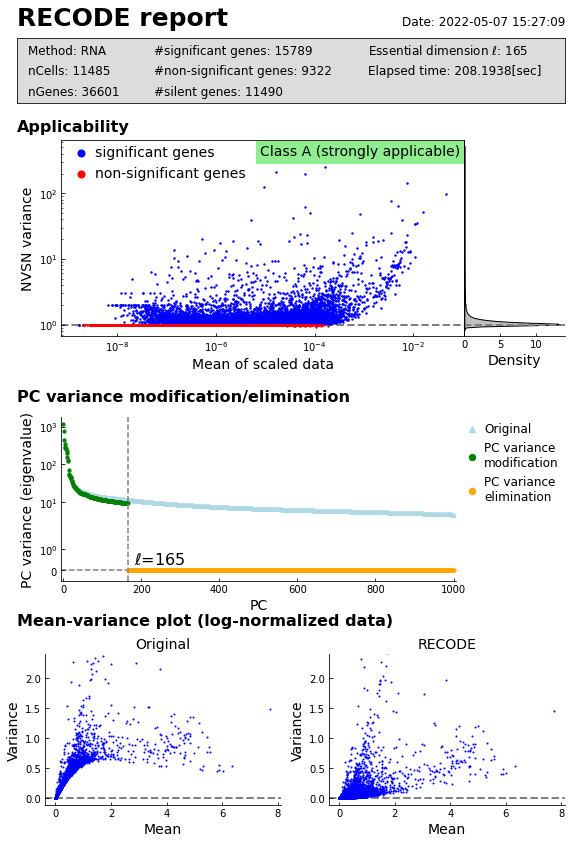

In [5]:
recode.report()

Gene expression

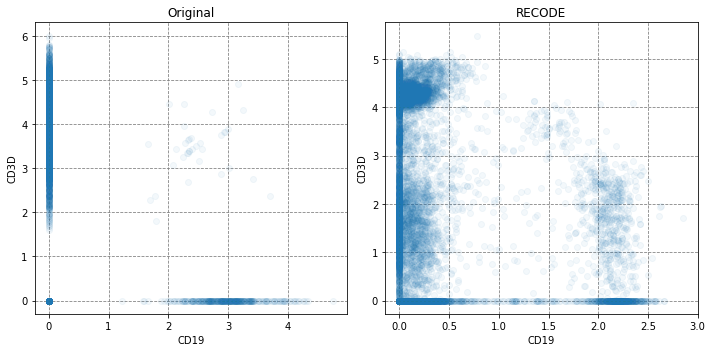

In [25]:
import matplotlib.pyplot as plt

genes = ['CD19','CD3D']
size_factor = 1e5
alpha = 0.05

plot_data = [np.log(size_factor*adata.X.toarray().T/np.sum(adata.X.toarray(),axis=1)+1).T,
             np.log(size_factor*adata.obsm['RECODE'].T/np.sum(adata.obsm['RECODE'],axis=1)+1).T]
names = ['Original','RECODE']

n_ax = len(plot_data)
fig,ax = plt.subplots(1,n_ax,figsize=(5*n_ax,5),tight_layout=True)
for i in range(n_ax):
    ax[i].scatter(plot_data[i][:,adata.var.index==genes[0]], plot_data[i][:,adata.var.index==genes[1]], alpha=alpha,zorder=10)
    ax[i].set_xlabel(genes[0])
    ax[i].set_ylabel(genes[1])
    ax[i].set_title(names[i])
    ax[i].grid(ls='--',color='gray',zorder=0)